In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR
import torch.distributions as distributions
from tqdm import tqdm
from copy import deepcopy

In [3]:
class RectifiedFlow:
  def euler(self,x_t,v,dt):
    x_t=x_t+v*dt
    return x_t
  def create_flow(self,x_1,t):
    x_0=torch.randn_like(x_1)
    t=t[:,None,None,None]
    x_t=t*x_1+(1-t)*x_0
    return x_t,x_0
  def mse_loss(self,x_1,x_0,v):
    loss=F.mse_loss(x_1-x_0,v)
    return loss

In [4]:
# MiniUnet MNIST 28*28 4090 3G左右显存
class DownLayer(nn.Module):
    """MiniUnet的下采样层 Resnet
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 time_emb_dim=16,
                 downsample=False):
        super(DownLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道 [B, dim] -> [B, in_channels]
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

        # 降采样
        self.downsample = downsample
        if downsample:
            self.pool = nn.MaxPool2d(2)

        self.in_channels = in_channels

    def forward(self, x, temb):
        # x: [B, C, H, W]
        res = x
        x += self.fc(temb)[:, :, None, None]  # [B, in_channels, 1, 1]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            res = self.shortcut(res)

        x = x + res

        if self.downsample:
            x = self.pool(x)

        return x


class UpLayer(nn.Module):
    """MiniUnet的上采样层
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 time_emb_dim=16,
                 upsample=False):
        super(UpLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, temb):
        # 上采样
        if self.upsample:
            x = self.upsample(x)
        res = x

        x += self.fc(temb)[:, :, None, None]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            res = self.shortcut(res)
        x = x + res

        return x


class MiddleLayer(nn.Module):
    """MiniUnet的中间层
    """

    def __init__(self, in_channels, out_channels, time_emb_dim=16):
        super(MiddleLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.act = nn.ReLU()

        # 线性层，用于时间编码换通道
        self.fc = nn.Linear(time_emb_dim, in_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x, temb):
        res = x

        x += self.fc(temb)[:, :, None, None]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        if self.shortcut is not None:
            x = self.shortcut(x)
        x = x + res

        return x


class MiniUnet(nn.Module):
    """采用MiniUnet，对MNIST数据做生成
        两个下采样block 一个中间block 两个上采样block
    """

    def __init__(self, base_channels=16, time_emb_dim=None):
        super(MiniUnet, self).__init__()

        if time_emb_dim is None:
            self.time_emb_dim = base_channels

        self.base_channels = base_channels

        self.conv_in = nn.Conv2d(1, base_channels, kernel_size=3, padding=1)

        # 多个Layer构成block
        self.down1 = nn.ModuleList([
            DownLayer(base_channels,
                      base_channels * 2,
                      time_emb_dim=self.time_emb_dim,
                      downsample=False),
            DownLayer(base_channels * 2,
                      base_channels * 2,
                      time_emb_dim=self.time_emb_dim)
        ])
        self.maxpool1 = nn.MaxPool2d(2)

        self.down2 = nn.ModuleList([
            DownLayer(base_channels * 2,
                      base_channels * 4,
                      time_emb_dim=self.time_emb_dim,
                      downsample=False),
            DownLayer(base_channels * 4,
                      base_channels * 4,
                      time_emb_dim=self.time_emb_dim)
        ])
        self.maxpool2 = nn.MaxPool2d(2)

        self.middle = MiddleLayer(base_channels * 4,
                                  base_channels * 4,
                                  time_emb_dim=self.time_emb_dim)

        self.upsample1 = nn.Upsample(scale_factor=2)
        self.up1 = nn.ModuleList([
            UpLayer(
                base_channels * 8,  # concat
                base_channels * 2,
                time_emb_dim=self.time_emb_dim,
                upsample=False),
            UpLayer(base_channels * 2,
                    base_channels * 2,
                    time_emb_dim=self.time_emb_dim)
        ])
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.up2 = nn.ModuleList([
            UpLayer(base_channels * 4,
                    base_channels,
                    time_emb_dim=self.time_emb_dim,
                    upsample=False),
            UpLayer(base_channels,
                    base_channels,
                    time_emb_dim=self.time_emb_dim)
        ])

        self.conv_out = nn.Conv2d(base_channels, 1, kernel_size=1, padding=0)

    def time_emb(self, t, dim):
        d=dim//2
        w=torch.randn(d,device='cuda')*30
        x_proj=t[:,None]*w[None,:]*2*math.pi
        return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)


    def forward(self, x, t):
        """前向传播函数

        Args:
            x (torch.Tensor): 输入数据，维度为[B, C, H, W]
            t (torch.Tensor): 时间，维度为[B]
        """
        # x:(B, C, H, W)
        # 时间编码加上
        x = self.conv_in(x)
        # 时间编码
        temb = self.time_emb(t, self.base_channels)
        # 这里注意，我们把temb和labelemb加起来，作为一个整体的temb输入到MiniUnet中，让模型进行感知！二者编码维度一样，可以直接相加！就把label的条件信息融入进去了！
        for layer in self.down1:
            x = layer(x, temb)
        x1 = x
        x = self.maxpool1(x)
        for layer in self.down2:
            x = layer(x, temb)
        x2 = x
        x = self.maxpool2(x)

        # 中间层
        x = self.middle(x, temb)

        # 上采样
        x = torch.cat([self.upsample1(x), x2], dim=1)
        for layer in self.up1:
            x = layer(x, temb)
        x = torch.cat([self.upsample2(x), x1], dim=1)
        for layer in self.up2:
            x = layer(x, temb)

        x = self.conv_out(x)
        return x

In [5]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

In [6]:
# Improved training configuration
epochs= 100  # More epochs
batch_size= 128  # Larger batch size for more stable gradients
lr= 5e-4  # Slightly higher learning rate initially
weight_decay= 1e-4  # Less regularization
ema_decay= 0.9999
grad_clip= 1.0
lr_schedule= True
step_size= 40  # Reduce LR later
gamma= 0.5 # More gradual LR reduction
lr_adjust_epoch= 25 # 学习率调整的epoch，降为原有的10%
batch_print_interval= 100 # 打印间隔，以batch为单位
device= 'cuda' # cuda、cpu、mps(only macbook)
checkpoint_save_interval= 10 # 模型保存间隔，以epoch为单位

In [7]:
transform = Compose([ToTensor()])  # 变换成tensor + 变为[0, 1]

dataset = MNIST(
        root='/workspace/Generative-model-DYI/data',
        train=True,  # 6w
        download=True,
        transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model=MiniUnet(base_channels=16).to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
schedular = StepLR(optimizer, step_size=step_size, gamma=gamma) 
rf= RectifiedFlow()
ema = EMA(model, decay=0.999, device=device)
for epoch in range(epochs):
  pbar=tqdm(dataloader,desc=f'Epoch {epoch}')
  for data,label in pbar:
    x_1=data
    t=torch.rand(x_1.size(0))
    x_t,x_0=rf.create_flow(x_1,t)
    x_t = x_t.to(device)
    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    t = t.to(device)
    optimizer.zero_grad()
    v_pred=model(x_t,t)
    loss=rf.mse_loss(x_1,x_0,v_pred)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    ema.update(model)
  if epoch % 5 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'ema_state_dict': ema.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss
        }, f"scalar_ckpt_{epoch}.pth")

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.37MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 304kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 753kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.75MB/s]
Epoch 99: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Using the EMA model for high-quality sample generation...
Generating 16 samples using EMA model...
Using 100 integration steps for high quality...
Visualizing samples...
Visualizing samples...


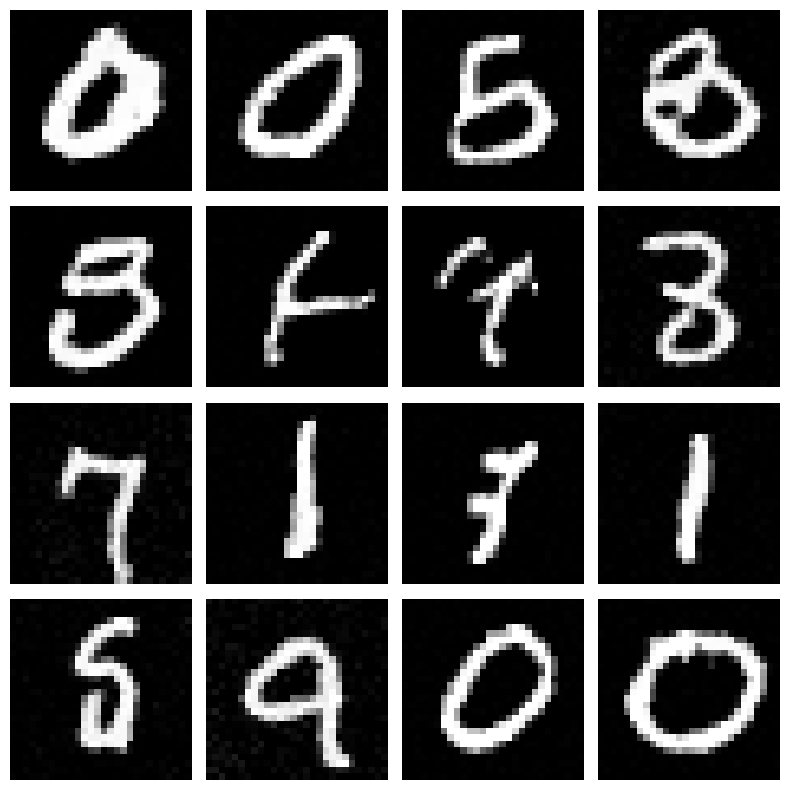

Sample generation completed!


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def sample(model, rf, num_samples, num_steps=50, device='cuda'):
    """Generate samples using the trained flow matching model
    
    Args:
        model: Trained MiniUnet model
        rf: RectifiedFlow instance
        num_samples: Number of samples to generate
        num_steps: Number of integration steps (improved from using num_samples as steps)
        device: Device to run on
    """
    model.eval()
    with torch.no_grad():
        dt = 1.0 / num_steps  # Use num_steps for better integration
        # Start from noise
        x_t = torch.randn(num_samples, 1, 28, 28, device=device)
        
        # Integrate the flow from t=0 to t=1
        for i in range(num_steps):
            t = torch.full((num_samples,), i * dt, device=device)
            v_pred = model(x_t, t)
            x_t = rf.euler(x_t, v_pred, dt)
        
        return x_t

def visualize_samples(samples, num_display=16, figsize=(8, 8)):
    """Visualize generated samples
    
    Args:
        samples: Generated samples tensor [B, 1, 28, 28]
        num_display: Number of samples to display
        figsize: Figure size
    """
    # Move to CPU and convert to numpy
    samples = samples.cpu().numpy()
    
    # Clamp values to [0, 1] range
    samples = np.clip(samples, 0, 1)
    
    # Calculate grid dimensions
    grid_size = int(np.sqrt(num_display))
    if grid_size * grid_size < num_display:
        grid_size += 1
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    axes = axes.flatten() if num_display > 1 else [axes]
    
    for i in range(num_display):
        if i < len(samples):
            # Remove channel dimension and display
            img = samples[i, 0]  # Shape: [28, 28]
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        else:
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def generate_samples_with_ema(ema_model, rf, num_samples=16, num_steps=100):
    """Generate samples using the EMA model directly
    
    Args:
        ema_model: The EMA model (ema.module)
        rf: RectifiedFlow instance
        num_samples: Number of samples to generate
        num_steps: Number of integration steps for better quality
    """
    print(f"Generating {num_samples} samples using EMA model...")
    print(f"Using {num_steps} integration steps for high quality...")
    
    # Generate samples using the EMA model
    samples = sample(ema_model, rf, num_samples, num_steps, device)
    
    print("Visualizing samples...")
    visualize_samples(samples, num_samples)
    
    return samples

# Use the EMA model for sampling (no need to load checkpoint)
sampling_model = ema.module
sampling_model.eval()

# Generate samples directly with the trained EMA model
print("Using the EMA model for high-quality sample generation...")
samples = generate_samples_with_ema(sampling_model, rf, num_samples=16, num_steps=100)
print("Sample generation completed!")